# $\mathsf{PyCelebi}$ code

### Import Python packages

In [1]:
#!/usr/bin/env python

import os, h5py, glob, galpy
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
import sys
from math import *
import math
import requests
from io import BytesIO
import time
from astropy import units
from astropy.cosmology import FlatLambdaCDM
#Galpy packages
from galpy.potential import ChandrasekharDynamicalFrictionForce, NFWPotential, PlummerPotential, HernquistPotential
from galpy.orbit import Orbit
from galpy.util import conversion
from galpy.potential import plotRotcurve

A new version of galpy (1.10.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!
/Users/pierreboldrini/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



### Accesing to Illustris TNG-300 data

In [2]:
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"2c7a4751e3ce4dcc7e7166da4dd32d02"}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return BytesIO(r.content)

r = get(baseUrl)

### Loading info concerning BCGs and their merger history

In [3]:
# Time  ############################
start_time = time.time()

#filelist = glob.glob("datahalo/*.h5")
filelist = glob.glob("halo_052.h5")

snaparr = np.asarray([x.split()[0] for x in open("TNG300-1_redshift_conv_time.txt").readlines()[:]]).astype(int)
redshiftarr = np.asarray([x.split()[1] for x in open("TNG300-1_redshift_conv_time.txt").readlines()[:]]).astype(float)
timearr = np.asarray([x.split()[2] for x in open("TNG300-1_redshift_conv_time.txt").readlines()[:]]).astype(float)

Grav = 4.302e-6 #Constante grav
little_h = 0.704
#scale=int(2000/10) #2000 time steps for orbtial integration over 10 Gyr with Galpy

file_sum_out = 'TNG300-1_GalpyBHsuccmergers_MBH.txt'

## Orbital integrations of next progenitors in BCG potential


idhalo halo_052 nb_merger 7



no_merger 6 redshift 1.90408954353277 Merger time 10.518


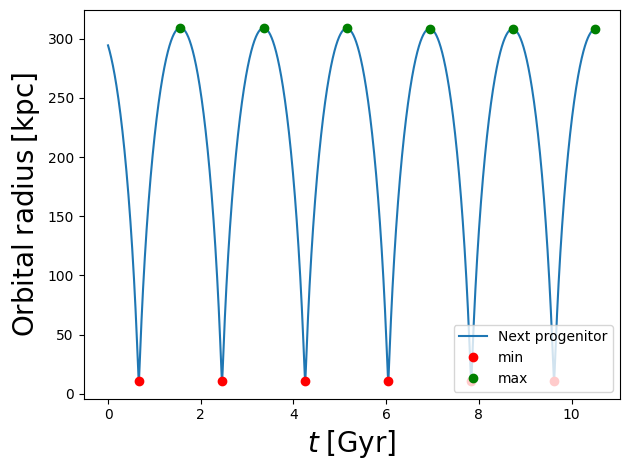



no_merger 5 redshift 1.66666955611447 Merger time 10.059000000000001


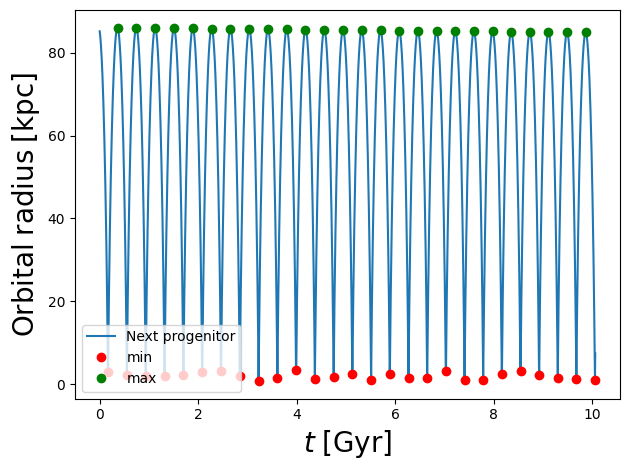



no_merger 4 redshift 1.60423452207311 Merger time 9.901


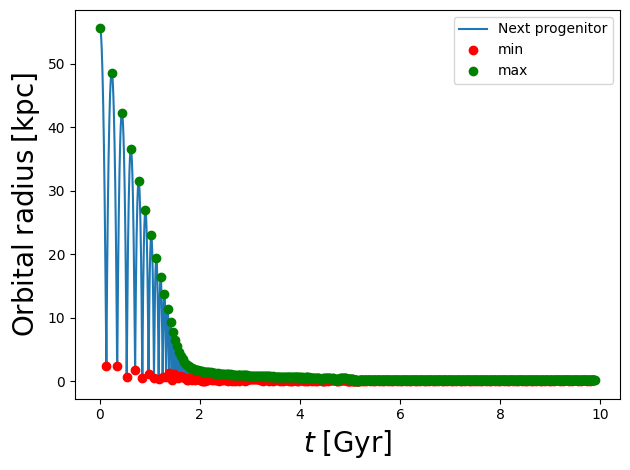

Time condition [0.53987444] Gyr
Td [9.36112556]
BH mass 1e9 Msol [42.54954555]


no_merger 3 redshift 1.53123902915761 Merger time 9.765


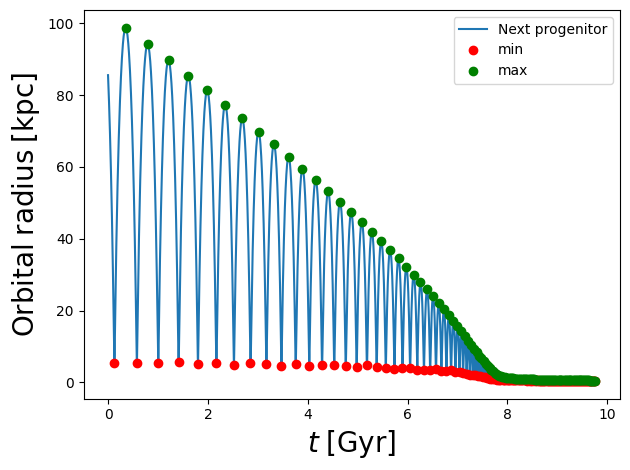

Time condition [8.1090045] Gyr
Td [1.6559955]
BH mass 1e9 Msol [58.30655603]


no_merger 2 redshift 1.41409822037252 Merger time 9.510000000000002


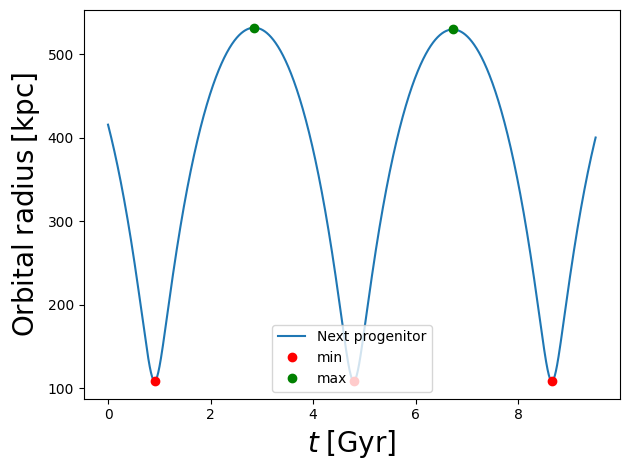



no_merger 1 redshift 0.851470900624649 Merger time 7.447000000000001


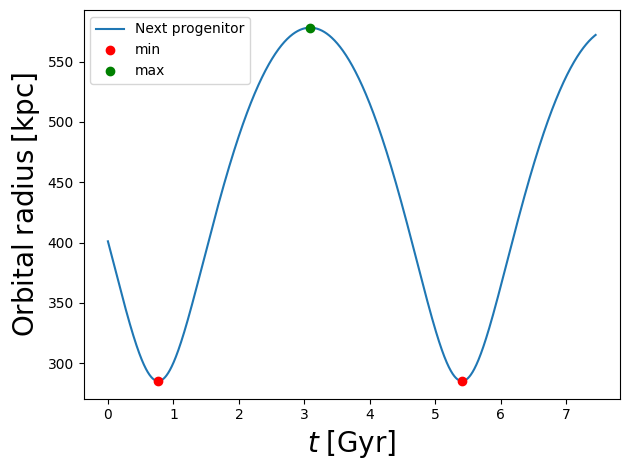



no_merger 0 redshift 0.732636182022312 Merger time 6.805000000000001


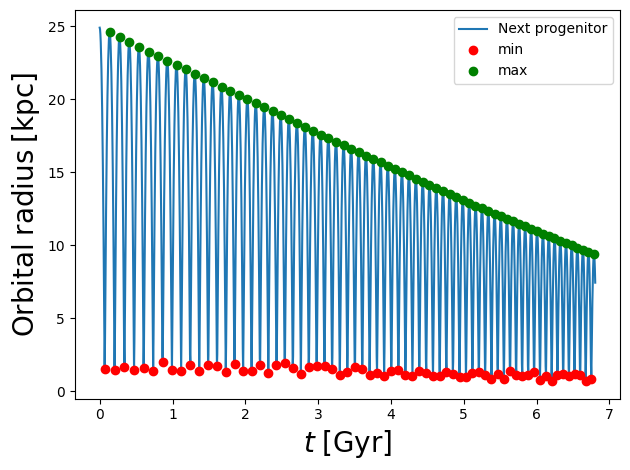

Time condition [3.29791994] Gyr
Td [3.50708006]
BH mass 1e9 Msol [56.20927987]
Temps d execution : 93.10018587112427 secondes ---


In [4]:
#nbh5 = 0
#switchid = 0
#for h5file in filelist:
#nbh5 = nbh5 + 1

for h5file in filelist:
    
    idhalo = h5file.split('/')[-1].split('.')[0]
    
    file_out = "./BHmergers_rad_succmerger_MBH/"+idhalo+".txt"
    with open(file_out,'w') as f_out :
        f_out.write('# nomerger Td ' \
                    'Ms_FP Ms_NP Mdm_FP Mdm_NP ' \
                    'rhms_FP rhms_NP rhmdm_FP rhmdm_FP ' \
                    'R Vi Vkick Vf ' \
                    'Rmax_BH Rmax0_BH Rmin0_BH \n')
        
    #-----------------------------------------------------------------
    
    mon_fichier = h5py.File(h5file, 'r') #this file contains all the necessary info about a given BCG
    
    nb_merger = len(mon_fichier["/FirstProg/redshift"]) # give the number of merger with the BCG between z=2 and z=0
    print('')
    print("idhalo", idhalo, "nb_merger", nb_merger)
    
    
    # Getting the the BCG stellar mass in order to calculate the BCG black hole mass later
    try :
        Ms_FP = mon_fichier["/FirstProg/Starmass"][nb_merger-1]
    except :
        with open('no_merger.txt', 'a') as f_no :
            f_no.write(idhalo+' \n')
        continue
    
    #---------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------
    
    print('')
    
    arrTd = np.array([])
    arrno_merger = np.array([])
    arrd = np.array([])
    #arrVf_BH = np.array([])
    arrah = np.array([])
    arrMdm = np.array([])
    arrMs = np.array([])
    arrap = np.array([])
    #arrVi_BH = np.array([])
    arrV_NP = np.array([])
    arreta = np.array([])
    arrMs_FP = np.array([])
    arrMdm_FP = np.array([])
    arrMs_NP = np.array([])
    arrMdm_NP = np.array([])
    arrrhms_FP = np.array([])
    arrrhmdm_FP = np.array([])
    arrrhms_NP = np.array([])
    arrrhmdm_NP = np.array([])
    arrR_BH = np.array([])
    
    #---------------------------------------------------------------------------------------
    # Reconstructing the merger history of the BCG
    #---------------------------------------------------------------------------------------
    
    for i in range(nb_merger-1, -1, -1) :
        
        #Loop from the first to recent mergers undergone by the BCG
        
        redshift = mon_fichier["/FirstProg/redshift"][i] 
        snap = mon_fichier["/FirstProg/snap"][i] # Snap n-1 where snap n correspond to the merger time
        Tage =  timearr[-1] - timearr[snap] # Time range for orbital integrations
        
        scale_factor = 1.0 / (1+redshift)
        
        print('')
        print('')
        print("no_merger", i,"redshift" , redshift,"Merger time", Tage)
        
        #------------------------------------------------------------------------------------
        # Initial conditions for next progenitors and the BCG
        #------------------------------------------------------------------------------------
        
        # Initial positions & velocities of the BCG
        xF, yF, zF = mon_fichier["/FirstProg/posx"][i], mon_fichier["/FirstProg/posy"][i], mon_fichier["/FirstProg/posz"][i]
        uF, vF ,wF = mon_fichier["/FirstProg/velx"][i], mon_fichier["/FirstProg/vely"][i], mon_fichier["/FirstProg/velz"][i]
        
        # Initial positions & velocities of the next progenitors
        xN, yN, zN = mon_fichier["/NextProg/posx"][i], mon_fichier["/NextProg/posy"][i], mon_fichier["/NextProg/posz"][i]
        uN, vN ,wN = mon_fichier["/NextProg/velx"][i], mon_fichier["/NextProg/vely"][i], mon_fichier["/NextProg/velz"][i]
    
        id_NP = mon_fichier["/NextProg/Id"][i]
        #print('id_NP, snap', id_NP, snap)
        # Half-mass radius of the next progenitors
        simNP = get("https://www.tng-project.org/api/TNG300-1/snapshots/"+str(snap)+"/subhalos/"+str(id_NP)+"/")
        rhmNP = simNP['halfmassrad']*scale_factor/little_h
    
        # Converting positions and velocities in the BCG frame
        x, y, z = xN - xF, yN - yF, zN - zF
        u, v, w = uN - uF, vN - vF, wN - wF
        
        
        #print('pos',x, y, z)
        #print('vel',u, v, w)
        #print('norm vel',np.sqrt(u**2 + v**2 + w**2))
    
        # Converting cartesian to cylindrical coordinates 
        R=sqrt(x**2 + y**2)
        Z=z
        vR=(x*u + y*v)/R      
        vT=(x*v - y*u)/R
        vZ = w
        phi=np.arctan2(y,x)
    
        #------------------------------------------------------------------------------------
        # Orbital initialization with Galpy
        #------------------------------------------------------------------------------------
        
        B=[R,vR,vT,Z,vZ,phi] # Galactocentric cylindrical coordinate
    
        orbit= Orbit([B[0]*units.kpc,B[1]*units.km/units.s,B[2]*units.km/units.s,
                     B[3]*units.kpc,B[4]*units.km/units.s,B[5]*(180/pi)*units.deg])
        
        #print('initial orbit position',orbit.x(),orbit.y(),orbit.z())
        
        #------------------------------------------------------------------------------------
        # Orbital initialization with Galpy
        #------------------------------------------------------------------------------------
        
        # DM component of the BCG
    
        Mdm = mon_fichier["/FirstProg/DMmass"][i] # mass
        rhmd = mon_fichier["/FirstProg/DMrhm"][i] # half-mass radius
    
        ah = rhmd/(sqrt(2) + 1)
        
        #print('DM mass 1e9 Msol', Mdm/1e9)
        #print('DM scales',rhmd,ah)
    
        HaloBCG = HernquistPotential(a=ah*units.kpc,amp=Mdm*units.Msun) # Assuming an Hernquist profile
    
        # Stellar component of the BCG
    
        Ms = mon_fichier["/FirstProg/Starmass"][i] # mass
        rhms = mon_fichier["/FirstProg/Starrhm"][i] # half-mass radius
    
        ap = rhms*sqrt((2**(2/3))-1)
        
        #print('Stellar mass 1e9 Msol', Ms/1e9)
        #print('Stellar scales',rhms,ap)
    
        StellarBCG = PlummerPotential(amp=Ms*units.Msun,b=ap*units.kpc) # Assuming a Plummer profile
    
        # Total potential of the BCG
    
        allpot = HaloBCG + StellarBCG
        
        #------------------------------------------------------------------------------------
        # Modelling dynamical friction for next progenitors
        #------------------------------------------------------------------------------------
        
        Mdms = mon_fichier["/NextProg/DMmass"][i] # DM mass of the next progenitor
        rhmds = mon_fichier["/NextProg/DMrhm"][i] # DM half-mass radius of the next progenitor
        
        Mdmstar = mon_fichier["/NextProg/Starmass"][i] # Stellar mass of the next progenitor
        rhmdstar = mon_fichier["/NextProg/Starrhm"][i] # Stellar half-mass radius of the next progenitor
        
        #print('Sat DM mass 1e9 Msol',Mdms/1e9)
        #print('Sat DM scale',rhmds)
        #print('Sat Stellar mass 1e9 Msol',Mdmstar/1e9)
        #print('Sat Stellar scale',rhmdstar)
        #print('rhmNP', rhmNP) # half-mass radius of the next progenitor
        
        cdf = ChandrasekharDynamicalFrictionForce(GMs=(Mdms+Mdmstar)*units.Msun,rhm=rhmNP*units.kpc,dens=allpot)
                
        #print('NP mass rh', Mdms, rhmds)
    
        #------------------------------------------------------------------------------------
        # Orbital integration with Galpy
        #------------------------------------------------------------------------------------
        
        scale=int(2000/10) # 2000 time steps for orbtial integration over 10 Gyr with Galpy
        duration=Tage
        
        if scale*round(Tage) < 100 :
            ts= np.linspace(0.,-duration,100)*units.Gyr
        else :
            ts= np.linspace(0.,-duration,scale*round(Tage))*units.Gyr 
    
        orbit.integrate(-ts,allpot+cdf)
        
        T = ts*-1 # Time
        Or = orbit.r(-ts) # Orbital radius
    
        x=T
        data = Or
        
        #plt.plot(x, data)
        #plt.show()
    
        #___ detection of local minimums and maximums ___
    
        b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1         # local min
        c = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1         # local max
        # +1 due to the fact that diff reduces the original index number
    
        try :
            #print(np.min(data[b]))
            ei = (data[c[0]] - data[b[1]])/(data[c[0]] + data[b[1]])
            #pericentre = data[b[1]] #kpc
        except :
            continue
            
        plt.plot(x.value, data,label="Next progenitor")
        plt.plot(x[b].value, data[b], "o", label="min", color='r')
        plt.plot(x[c].value, data[c], "o", label="max", color='g')
        
        #------------------------------------------------------------------------------------
        # Plot orbit of next progenitors
        #------------------------------------------------------------------------------------
    
        plt.xlabel(r'$t\;[\mathrm{Gyr}]$',fontsize=20)
        plt.ylabel(r'$\mathrm{Orbital\;radius}\;[\mathrm{kpc}]$',fontsize=20)
    
        plt.legend()
        plt.tight_layout()
        plt.show()
        #plt.close()
                
        #------------------------------------------------------------------------------------
        # Checking if next progenitor orbit is radial or not
        #------------------------------------------------------------------------------------
        
        RHMs_NP = mon_fichier["/NextProg/Starrhm"][i]
        RHMdm_NP = mon_fichier["/NextProg/DMrhm"][i]
        
        Ms_NP = mon_fichier["/NextProg/Starmass"][i]
        Mdm_NP = mon_fichier["/NextProg/DMmass"][i]
        Mtot_NP = Ms_NP + Mdm_NP
        
        Ms_FP = mon_fichier["/FirstProg/Starmass"][i]
        Mdm_FP = mon_fichier["/FirstProg/DMmass"][i]
        Mtot_FP = Ms_FP + Mdm_FP
        
        RHMdm_FP = mon_fichier["/FirstProg/DMrhm"][i]
        RHMs_FP = mon_fichier["/FirstProg/Starrhm"][i]
        
        #-------------------------------------------------------------------------------------
        switch_MBH = 0
        for d in data :
    
            B1=HaloBCG.vcirc(d*units.kpc)
            B2=StellarBCG.vcirc(d*units.kpc)
            
            Mint_BCG=((B1**2 + B2**2)*d)/Grav
    
            if rhmNP >= d and Mtot_NP >= Mint_BCG :
            
                Td = x[np.where(data == d)]
                
                print('Time condition', Td)
                #print("RHMs_NP", RHMs_NP, "d", d, "Mtot_NP en 1e9", Mtot_NP/1e9, "Mint_BCG en 1e9", Mint_BCG/1e9)
                #print("RHMdm_NP", rhmds)
                
                RR=orbit.r(-ts) # orbital radius
                v1=orbit.vR(-ts)
                v2=orbit.vT(-ts)
                v3=orbit.vz(-ts)
    
                V_NP = np.sqrt(v1 **2 + v2**2 + v3**2) #sat, td
                V_NP = V_NP[np.where(data == d)]
                #print("V_NP", V_NP)
                
                #------------------------------------------------------------
                #Mass BH
                if switch_MBH == 0 : #first merger
                    switch_MBH = 1
                    
                    id_FP = mon_fichier["/FirstProg/Id"][i]
                    simFP = get("https://www.tng-project.org/api/TNG300-1/snapshots/"+str(snap)+"/subhalos/"+str(id_FP)+"/")
                    timesnap = timearr[np.where(snaparr == snap)]
                                        
                    #print("https://www.tng-project.org/api/TNG300-1/snapshots/"+str(snap)+"/subhalos/"+str(id_FP)+"/")
                    
                    while timearr[-1] - timesnap >= Tage - Td.value :
                        
                        #print('age Tsnap, Td ', timearr[-1] - timesnap, Tage - Td.value)
                        
                        Ms_FP1 = simFP["mass_stars"]*1e10/0.704
                        timesnap1 = timesnap
                        
                        irl_FP = simFP["related"]["sublink_descendant"]
                        snaptime = int(irl_FP.split('/')[-4])
                        simFP = get(irl_FP)
                        
                        timesnap = timearr[np.where(snaparr == snaptime)]
                        
                    Ms_FP2 = simFP["mass_stars"]*1e10/0.704
                    timesnap2 = timesnap
                    
                    Ms_FP = (Ms_FP2 - Ms_FP1)/(timesnap1 - timesnap2)*(Tage - Td.value) + Ms_FP2 - (Ms_FP2 - Ms_FP1)/(timesnap1 - timesnap2)*(timearr[-1] - timesnap2)
                    
                    #print('Ms1, Ms2', Ms_FP1, Ms_FP2)
                    #print('timesnap1, timesnap2', timearr[-1] - timesnap1, timearr[-1] - timesnap2)
                    print('Td', Tage - Td.value)
                
                    # Determining the BH mass at the first Td
                    Mtot_BH = 0.06*Ms_FP
    
                    print('BH mass 1e9 Msol', Mtot_BH/1e9 )
    
                    Rs = pow(10,-16)*Mtot_BH # Schwarzschild radius in kpc
                    R_BH = 100*Rs #100*Rs #pc
        
                else :
                    switch_MBH = 1
                
                eta = Mtot_NP/Mint_BCG
    
                #------------------------------------------------------------
                # Saving data for next BH orbital integrations
                #------------------------------------------------------------
    
                arrTd = np.append(arrTd, Tage - Td.value)
                arrd = np.append(arrd, d)
                arrno_merger = np.append(arrno_merger, i)
                #arrVf_BH = np.append(arrVf_BH, Vf_BH)
                arrah = np.append(arrah, ah)
                arrMdm = np.append(arrMdm, Mdm)
                arrMs = np.append(arrMs, Ms)
                arrap = np.append(arrap, ap)
                #arrVi_BH = np.append(arrVi_BH, Vi_BH)
                arrV_NP = np.append(arrV_NP, V_NP)
                arreta = np.append(arreta, eta)
                arrMs_FP = np.append(arrMs_FP, Ms_FP)
                arrMdm_FP = np.append(arrMdm_FP, Mdm_FP)
                arrMs_NP = np.append(arrMs_NP, Ms_NP)
                arrMdm_NP = np.append(arrMdm_NP, Mdm_NP)
                arrrhms_FP = np.append(arrrhms_FP, RHMs_FP)
                arrrhmdm_FP = np.append(arrrhmdm_FP, RHMdm_FP)
                arrrhms_NP = np.append(arrrhms_NP, RHMs_NP)
                arrrhmdm_NP = np.append(arrrhmdm_NP, RHMdm_NP)
                arrR_BH = np.append(arrR_BH, R_BH)
                
                break
            else :
                continue

# End of the computation
print("Temps d execution : %s secondes ---" % (time.time() - start_time))

## Orbital integrations of central BHs kicked by satellite mergers


0

New merger 4.0
Black hole mass 1e9 Msol 56.20927987086181
duration merger 5.854045505597687
BH perturbed by the progenitor


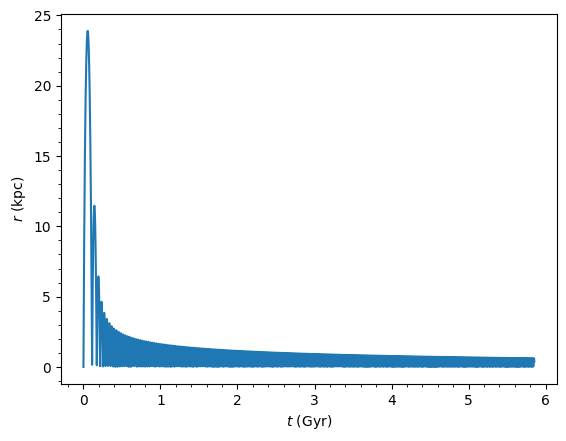

1

New merger 0.0
Black hole mass 1e9 Msol 56.20927987086181


In [ ]:
# Sorted the data with Td
sorted_arrno_merger = [p for _, p in sorted(zip(arrTd, arrno_merger), reverse=True)]
sorted_arrd = [p for _, p in sorted(zip(arrTd, arrd), reverse=True)]
sorted_arrah = [p for _, p in sorted(zip(arrTd, arrah), reverse=True)]
sorted_arrMdm = [p for _, p in sorted(zip(arrTd, arrMdm), reverse=True)]
sorted_arrMs = [p for _, p in sorted(zip(arrTd, arrMs), reverse=True)]
sorted_arrap = [p for _, p in sorted(zip(arrTd, arrap), reverse=True)]
sorted_arrV_NP = [p for _, p in sorted(zip(arrTd, arrV_NP), reverse=True)]
sorted_arreta = [p for _, p in sorted(zip(arrTd, arreta), reverse=True)]
sorted_arrMs_FP = [p for _, p in sorted(zip(arrTd, arrMs_FP), reverse=True)]
sorted_arrMdm_FP = [p for _, p in sorted(zip(arrTd, arrMdm_FP), reverse=True)]
sorted_arrMs_NP = [p for _, p in sorted(zip(arrTd, arrMs_NP), reverse=True)]
sorted_arrMdm_NP = [p for _, p in sorted(zip(arrTd, arrMdm_NP), reverse=True)]
sorted_arrrhms_FP = [p for _, p in sorted(zip(arrTd, arrrhms_FP), reverse=True)]
sorted_arrrhmdm_FP = [p for _, p in sorted(zip(arrTd, arrrhmdm_FP), reverse=True)]
sorted_arrrhms_NP = [p for _, p in sorted(zip(arrTd, arrrhms_NP), reverse=True)]
sorted_arrrhmdm_NP = [p for _, p in sorted(zip(arrTd, arrrhmdm_NP), reverse=True)]
sorted_arrR_BH = [p for _, p in sorted(zip(arrTd, arrR_BH), reverse=True)]

sorted_arrTd = sorted(arrTd, reverse=True) # Age of Universe at Td

#---------------------------------------------------------------------------------
# Checking if there is at least one radial merger    
try :
    R_BH = sorted_arrR_BH[0]
except :
    pass
print('')

#------------------------------------------------------------------------------------
# BH dynamics
#------------------------------------------------------------------------------------    

torbit_BH = np.array([])
rorbit_BH = np.array([])

idxnextTd = 0

nbmergersBH = 0
for idx, Td in enumerate(sorted_arrTd) :            
    # from the first to recent mergers

    print(idx)
    #------------------------------------------------------------------------------------
    # Initial conditions for the BH
    #------------------------------------------------------------------------------------

    if idx < idxnextTd :
        continue
    else :
        
        #Vf_BH = sorted_arrVf_BH[idx]
        d = sorted_arrd[idx]
        ah = sorted_arrah[idx]
        Mdm = sorted_arrMdm[idx]
        Ms = sorted_arrMs[idx]
        ap = sorted_arrap[idx]
        V_NP = sorted_arrV_NP[idx]
        eta = sorted_arreta[idx]
        
        
        HaloBCG = HernquistPotential(a=ah*units.kpc,amp=Mdm*units.Msun)
        StellarBCG = PlummerPotential(amp=Ms*units.Msun,b=ap*units.kpc)

        #------------------------------------------------------------------------------------
        # Calculating the BH velocity kick
        #------------------------------------------------------------------------------------
        
        allpot = HaloBCG + StellarBCG
        A1=HaloBCG.vcirc(R_BH*units.kpc)
        A2=StellarBCG.vcirc(R_BH*units.kpc)

        Vcirc=np.sqrt(A1**2 + A2**2) #Vi_BH
        Vi_BH = Vcirc

        eps = V_NP**2 / Vi_BH**2
        Vf_BH = np.sqrt((1 + eta*eps)/(1 + eta))*Vi_BH
                
        print('')
        print('New merger', sorted_arrno_merger[idx])
        #print('Time condition', Td, 'd', d, 'Vf BH', Vf_BH)
        
        nbmergersBH = nbmergersBH + 1

    #------------------------------------------------------------------------------------
    # Defining BCG potential
    #------------------------------------------------------------------------------------

    HaloBCG = HernquistPotential(a=ah*units.kpc,amp=Mdm*units.Msun)
    StellarBCG = PlummerPotential(amp=Ms*units.Msun,b=ap*units.kpc)

    allpot = HaloBCG + StellarBCG

    #------------------------------------------------------------------------------------
    # BH dynamical friction in the BCG potential
    #------------------------------------------------------------------------------------
    print('Black hole mass 1e9 Msol',Mtot_BH[0]/1e9)
    cdfbh = ChandrasekharDynamicalFrictionForce(GMs=Mtot_BH[0]*units.Msun,rhm=0*units.kpc,dens=allpot)

    str_out = str(idx)+' '+str(Td)+' ' \
                +str(sorted_arrMs_FP[idx])+' '+str(sorted_arrMs_NP[idx])+' ' \
                +str(sorted_arrMdm_FP[idx])+' '+str(sorted_arrMdm_NP[idx])+' ' \
                +str(sorted_arrrhms_FP[idx])+' '+str(sorted_arrrhms_NP[idx])+' ' \
                +str(sorted_arrrhmdm_FP[idx])+' '+str(sorted_arrrhmdm_NP[idx])
    
    # First kick by the radial merger
    
    if idx == 0 :
        #print('R_BH, vf_BH', R_BH, Vf_BH)
        C = [R_BH,Vf_BH,0,0,0,0] # Galactocentric cylindrical coordinate [R,vR,vT,Z,vZ,phi]
                                 
        str_out = str_out+' '+str(R_BH)+' '+str(Vf_BH)+' '+str(0.0)+' '+str(Vf_BH)
        
    # Subsequent kicks                            
    else :

        #print('R, vNf, Z', R, vNf, Z)
        C = [R,vNf,0,Z,0,0]
        
        str_out = str_out+' '+str(R)+' '+str(vN)+' '+str(Vf_BH)+' '+str(vNf)

    switch_mergerbh = 0
    while switch_mergerbh == 0 and idxnextTd + 1 <= len(sorted_arrTd) - 1 :
        #while next merger has not happened and next potential merger exists

        orbitbh= Orbit([C[0]*units.kpc,C[1]*units.km/units.s,C[2]*units.km/units.s,
             C[3]*units.kpc,C[4]*units.km/units.s,C[5]*(180/pi)*units.deg])

        idxnextTd = idxnextTd + 1

        if idx == len(sorted_arrTd) - 1 : #last potential merger
            duration = abs(Td)
        else :
            duration = abs(Td - sorted_arrTd[idxnextTd])
        d = sorted_arrd[idxnextTd]

        print('duration merger', duration)
        if 10*scale*round(duration) < 100 :
            tsbh= np.linspace(0.,-duration,100)*units.Gyr
            timescale = 100
        else :
            tsbh= np.linspace(0.,-duration,10*scale*round(duration))*units.Gyr 
            timescale = 10*scale*round(duration)
        
        orbitbh.integrate(-tsbh,allpot+cdfbh) #need to invert time for dynamical friction
        orbitbh.plot(d1='t',d2='r')


        Tf = tsbh*-1 # reverse Time
        Orf = orbitbh.r(-tsbh) # Orbital radius

        xf = Tf
        dataf = Orf

        rBH = dataf[-1] #Projected distance

        #print('rBH, d', rBH, d)

        #---------------------------------------------------------------------------
        #---------------------------------------------------------------------------
        #check if NP affects the off-centered BH at the merger time
        #---------------------------------------------------------------------------


        if rBH < d :
            print('BH perturbed by the progenitor')

            switch_mergerbh = 1

            #print('Merger, integrate orbit BH')
            #print('BH merger condition Tdi Tdf', Td, sorted_arrTd[idxnextTd], sorted_arrno_merger[idxnextTd])
            # BH Initial conditions
            vR = orbitbh.vR(-tsbh)[-1]
            vT = orbitbh.vT(-tsbh)[-1]
            vZ = orbitbh.vz(-tsbh)[-1]

            vN = sqrt(vR**2 + vT**2 + vZ**2)

            #print("velbh",vN)

            R = orbitbh.R(-tsbh)[-1]
            Z = orbitbh.z(-tsbh)[-1]

            eta = sorted_arreta[idxnextTd]
            V_NP = sorted_arrV_NP[idxnextTd]
            eps = V_NP**2 / vN**2

            Vf_BH = np.sqrt((1 + eta*eps)/(1 + eta))*vN

            #print('Vn, VfBH', vN, Vf_BH)
            vNf = abs(vN) + abs(Vf_BH)
            C = [R,vNf,0,Z,0,0]

            #print('Vnf', vNf)

            torbit_BH = np.append(torbit_BH, np.linspace(Td, sorted_arrTd[idxnextTd], timescale))
            rorbit_BH = np.append(rorbit_BH, dataf)

            plt.show()
            
            bf = (np.diff(np.sign(np.diff(dataf))) > 0).nonzero()[0] + 1         # local min
            cf = (np.diff(np.sign(np.diff(dataf))) < 0).nonzero()[0] + 1         # local max

            try :
                str_out = str_out+' '+str(np.max(dataf))+' '+str(dataf[cf[-1]])+' '+str(dataf[bf[-1]])
            except :
                str_out = str_out+' '+str(np.max(dataf))+' '+str(dataf[-1])+' '+str(dataf[-1])
            
            with open(file_out,'a') as f_out :
                f_out.write(str_out+' \n')
                                 
            break

        else :
            #plt.close()
            print('BH not affected')
            plt.show()
            continue

    if switch_mergerbh == 0 : # If it corresponds to the last merger

        print('last merger')

        duration = Td

        orbitbh= Orbit([C[0]*units.kpc,C[1]*units.km/units.s,C[2]*units.km/units.s,
             C[3]*units.kpc,C[4]*units.km/units.s,C[5]*(180/pi)*units.deg])

        if 10*scale*round(duration) < 100 :
            tsbh= np.linspace(0.,-duration,100)*units.Gyr
            timescale = 100
        else :
            tsbh= np.linspace(0.,-duration,10*scale*round(duration))*units.Gyr 
            timescale = 10*scale*round(duration)
        
        orbitbh.integrate(-tsbh,allpot+cdfbh)
        dataf = orbitbh.r(-tsbh)

        torbit_BH = np.append(torbit_BH, np.linspace(Td, 0, timescale))
        rorbit_BH = np.append(rorbit_BH, dataf)

        Tf = tsbh*-1 # Time
        Orf = orbitbh.r(-tsbh) # Orbital radius

        xf = Tf
        dataf = Orf

        rBH = dataf[-1] #Projected distance

        orbitbh.plot(d1='t',d2='r')
        #plt.ylim(0, 10)
        plt.show()
        
        bf = (np.diff(np.sign(np.diff(dataf))) > 0).nonzero()[0] + 1         # local min
        cf = (np.diff(np.sign(np.diff(dataf))) < 0).nonzero()[0] + 1         # local max
        
        try :
            str_out = str_out+' '+str(np.max(dataf))+' '+str(dataf[cf[-1]])+' '+str(dataf[bf[-1]])
        except :
            str_out = str_out+' '+str(np.max(dataf))+' '+str(dataf[-1])+' '+str(dataf[-1])
        
        with open(file_out,'a') as f_out :
            f_out.write(str_out+' \n')

        break

    else :
        pass

    #-------------------------------------------------------------------------------------

bf = (np.diff(np.sign(np.diff(rorbit_BH))) > 0).nonzero()[0] + 1         # local min
cf = (np.diff(np.sign(np.diff(rorbit_BH))) < 0).nonzero()[0] + 1         # local max
                    
print('Complete BH orbit')
plt.plot(torbit_BH*-1, rorbit_BH)
#plt.ylim(0, 2)
plt.xlabel(r'$t\;[\mathrm{Gyr}]$',fontsize=20)
plt.ylabel(r'$\mathrm{Orbital\;radius}\;[\mathrm{kpc}]$',fontsize=20)
plt.tight_layout()
#plt.savefig('plots_bh_orbit_MBH/'+idhalo+'.png')
plt.show()

try :
    with open(file_sum_out, 'a') as fsum :
        fsum.write(idhalo+' '+ str(nb_merger)+' '+str(nbmergersBH)+' '+str(Mtot_BH)+' '+str(R_BH)+' '+str(torbit_BH[np.argmax(rorbit_BH)]*-1)+' '+str(np.max(rorbit_BH))+ \
                   ' '+str(Td)+' '+str(rorbit_BH[-1])+' '+str(rorbit_BH[cf[-1]])+' '+str(rorbit_BH[bf[-1]])+' \n')
except Exception as e:
    print(f"An error occurred: {e}")


# End of the computation
print("Temps d execution : %s secondes ---" % (time.time() - start_time))